In [65]:
import nltk
import pandas
import sklearn 
import torch
import seaborn
import matplotlib.pyplot as plt

In [ ]:
# downloading corpus + tagset

nltk.download('brown')
nltk.download('universal_tagset')

In [38]:
print(torch.cuda.is_available())

True


In [39]:
# sentences

sentences = nltk.corpus.brown.tagged_sents(tagset= 'universal')

In [40]:
print(sentences)

[[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')], [('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('City

In [41]:
# test-train split

training_sentences, testing_sentences = sklearn.model_selection.train_test_split(sentences, test_size = 0.001, random_state = 42)

In [42]:
# isolating tagged words

training_words_tagged = [word for sentence in training_sentences for word in sentence]
testing_words_tagged = [word for sentence in testing_sentences for word in sentence]

print(len(training_words_tagged))
print(len(testing_words_tagged))


1160238
954


In [43]:
# listing all the training words and tags in order

training_taglist = [tag for word, tag in training_words_tagged]
training_wordlist = [word for word, tag in training_words_tagged]

# listing words and tags without duplication

unique_taglist = list(set(training_taglist))
unique_wordlist = list(set(training_wordlist))

print(len(unique_taglist), len(unique_wordlist))
print(len(training_taglist))
print(len(training_wordlist))

print(unique_taglist)

12 56043
1160238
1160238
['NOUN', 'PRT', 'ADP', 'PRON', 'DET', 'NUM', 'CONJ', 'VERB', 'ADJ', 'X', 'ADV', '.']


In [44]:
# emission probability
# this is the probability of a word given a tag

def ep_word_tag(word, tag):
    
    # number of pairs containing the tag given

    pairlist = [tup for tup in training_words_tagged if tup[1] == tag]
    len_pairlist = len(pairlist)

    # number of pairs containing the tag and the word given

    matching_pairlist = [tup for tup in pairlist if tup[0] == word]
    len_matchlist = len(matching_pairlist)

    # avoid division by 0

    if len_pairlist == 0:
        return 0
    
    # emission probability

    emission_probability = len_matchlist / len_pairlist 
    return emission_probability


In [45]:
# transition probability
# this is the probability of a tag given another tag in the previous index

def tp_tag_tag(tag2, tag1):

    # occurences of the previous tag (tag 1)

    tag1_count = len([tag for tag in training_taglist if tag == tag1])

    # initializing matchcount

    tag1_tag2_count = 0

    # instances of tag 2 occuring where tag 1 is directly before it

    for idx in range(len(training_taglist) - 1):
        if training_taglist[idx] == tag1 and training_taglist[idx + 1] == tag2:
            tag1_tag2_count += 1

    # avoiding division by 0

    if tag1_count == 0:
        return 0
    
    # transition probability
    
    transition_probability = tag1_tag2_count / tag1_count
    return transition_probability

In [46]:
# initializing a tensor of the shape needed for the transition matrix

tag_transition_matrix = torch.zeros((len(unique_taglist), len(unique_taglist)), dtype = float).cuda()

In [47]:
# transition matrix w/ probabilities for each tag pair

for i, tag1 in enumerate(unique_taglist):

    for j, tag2 in enumerate(unique_taglist):
        
        tag_transition_matrix[i, j] = tp_tag_tag(tag2, tag1)

print(tag_transition_matrix)

tensor([[1.4974e-01, 1.7978e-02, 2.4475e-01, 2.0324e-02, 1.6257e-02, 8.1283e-03,
         5.9873e-02, 1.5895e-01, 1.3002e-02, 3.4140e-04, 2.6717e-02, 2.8395e-01],
        [3.5799e-02, 1.1240e-02, 9.0757e-02, 6.8780e-03, 8.3509e-02, 5.0998e-03,
         1.2246e-02, 6.2255e-01, 1.8923e-02, 6.7103e-05, 3.6135e-02, 7.6799e-02],
        [2.5843e-01, 1.4262e-02, 2.0311e-02, 6.9774e-02, 4.5565e-01, 3.0093e-02,
         1.8873e-03, 4.1237e-02, 8.2626e-02, 4.6318e-04, 1.5506e-02, 9.7544e-03],
        [8.8260e-03, 2.3719e-02, 5.5878e-02, 8.2173e-03, 1.7571e-02, 9.9420e-04,
         1.1383e-02, 7.0622e-01, 9.4956e-03, 2.0290e-05, 5.3950e-02, 1.0372e-01],
        [6.2645e-01, 2.0159e-03, 9.0716e-03, 9.9335e-03, 5.9455e-03, 9.7728e-03,
         6.5736e-04, 6.4699e-02, 2.3975e-01, 1.4170e-03, 1.7515e-02, 1.2775e-02],
        [3.8105e-01, 5.4494e-03, 1.3193e-01, 9.2169e-03, 1.4397e-02, 2.1865e-02,
         3.8751e-02, 4.5815e-02, 5.9405e-02, 2.0183e-04, 2.0654e-02, 2.7126e-01],
        [2.4363e-01, 2

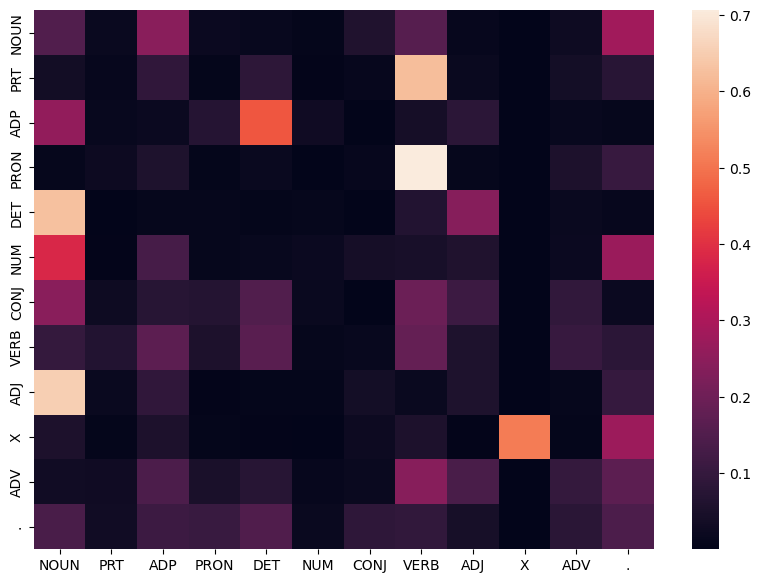

In [77]:
plt.figure(figsize = (10, 7))
seaborn.heatmap(pandas.DataFrame(tag_transition_matrix.cpu(), columns = unique_taglist, index = unique_taglist))
plt.show()

In [48]:
# creating a dictionary to easily access the indices of each tag in the matrix

tag_indices = {tag : idx for idx, tag in enumerate(unique_taglist)}
print(tag_indices)

{'NOUN': 0, 'PRT': 1, 'ADP': 2, 'PRON': 3, 'DET': 4, 'NUM': 5, 'CONJ': 6, 'VERB': 7, 'ADJ': 8, 'X': 9, 'ADV': 10, '.': 11}


In [58]:
# viterbi algorithm to find best fitting tag sequence

def viterbi(input_sentence):

    # specifying dimensions

    sentence_length = len(input_sentence)
    tags_length = len(unique_taglist)
    
    # initializing state_probabilities to store probabilities per word

    state_probabilities = torch.zeros(sentence_length, tags_length,).cuda()

    #initializing max_states to store max tag probability for word

    max_states = torch.zeros(sentence_length, dtype = int).cuda()

    # calculate tag probabilites per word
    
    for idx, word in enumerate(input_sentence):
        
        if idx == 0:

            # specifying the previous tag (typically a punctuation) for the first word in the sentence

            prev_tag_idx = tag_indices['.']
        else:

            # specifying the previous tag by singling out the index of the highest probability tag

            prev_tag_idx = torch.argmax(state_probabilities[idx - 1])
        
        for tag_idx, tag in enumerate(unique_taglist):

            #calculating state probabilities and filling up the tensor

            transition_prob = tag_transition_matrix[prev_tag_idx][tag_idx]
            state_probabilities[idx][tag_idx] = transition_prob * ep_word_tag(word, tag)

        print(f"{idx + 1} / {sentence_length}", end = "\r")

    # evaluating the highest probability tag index per word
    
    max_states = torch.argmax(state_probabilities, dim=1)
    state = [unique_taglist[idx] for idx in max_states]
    
    return zip(input_sentence, state)


In [59]:
# listing the testing tags and words in order

test_taglist = [tag for word, tag in testing_words_tagged]
test_wordlist = [word for word, tag in testing_words_tagged]

In [60]:
# feeding the testing wordlist into viterbi, treating it as a large sentence
# this took a really long time to run for a larger test set, so i made it relatively a lot smaller

prediction_dict = viterbi(test_wordlist)

# listing the predicted tags in order

predicted_tags = [tag for word, tag in prediction_dict]

In [61]:
# lengths of the wordlist, true taglist, and predicted taglist; they should all be equal

print(len(test_wordlist))
print(len(test_taglist))
print(len(predicted_tags))

954
954
954


In [62]:
# converting to a dataframe

data = {"words" : test_wordlist, "true_tags" : test_taglist, "predicted_tags" : predicted_tags}

test_df = pandas.DataFrame(data)
test_df

,words,true_tags,predicted_tags
0,Open,ADJ,NOUN
1,market,NOUN,NOUN
2,policy,NOUN,NOUN
3,And,CONJ,CONJ
4,you,PRON,PRON
...,...,...,...
949,reproducible,ADJ,ADJ
950,rates,NOUN,NOUN
951,of,ADP,ADP
952,reaction,NOUN,NOUN


In [63]:
#evaluating accuracy

sklearn.metrics.accuracy_score(test_df['true_tags'], test_df['predicted_tags'])

0.9570230607966457